# BMEN 509 - Laboratory 3 - Ultrasound Imaging


##### UCID: 30088413
#### Name: Ibrahim Asad

The purpose of this laboratory is to become familiar with ultrasound imaging, from acquisition to image reconstruction.

In this exercise, you will demonstrate:

1. Data acquistion fundamentals
2. An ability to perfom basic signal processing 
3. An understanding of ultrasound image reconstruction

Your rubric is as follows:
<img src="NotebookImages/RubricLab3.PNG" alt="RubricLab3" width="600"/>

Please use this notebook to complete your assignment. Sections to be completed are blank and are marked by `TODO`. Please submit both the Python notebook (.ipynb) and a PDF export (File > Download as > PDF).

### Objectives
1. Get hands on experience with real ultrasound data acquisition
2. Practice good safety and operating procedures when using ultrasound equipment
3. Gain an understanding of the apparatus used in ultrasound signal acquisition
4. Perform image reconstruction with data collected in the lab

## Question 1 - Ultrasound Transducer Characteristics

You have a transducer for transmitting signals and receiving reflections. Tranducers have many characteristics that influence the acquired image. Record the characteristics of the transducer used in the lab. List 3 characteristics and briefly explain their impact on the captured image.

The transducer in this lab used is a single element transducer and is a cylinder object with text. This text is not seen in the video so we were provided a separate image showing the values that were written on the transducer. 
“V320
7.5MHZ/0.f”
F=60mm PTF
837222

List 3 characteristics and briefly explain their impact on the captured image.

1. Single Element Transducer - Only Sending One wave and receiving one Wave back at a time. causing the image to lack as much clarity as it could have 
2. The Frequency of the Transducer is 7.5MHz - The Frequency is used to help achieve a better resolution, so if the out has a larger frequency then the image will have a better resolution
3. F = 60mm Which is the Focal length which is how focused an image will appear when looking at a object and we try to get near the focus to get the best results

## Question 2 - Acquisition System

The connections of the transducer to the pulser/receiver and to the acquisition system (oscilloscope) were checked following the the description in the lab notes. 

Provide a brief set-up methodology description with schematic drawing of these connections:

**You Connect your Pulse/Reciever to the Oscillopse which then is connected to the Transducer and that is point towards an object through a medium, in this case de-ionized water. The Oscillope is also connected to power through a GFCI for saftey purposes** 

See PDF for Skectch.

Provide a brief safety measures description as discussed during the lab, and any measurements done during this procedure.

**Use a Tool to measure that the medium (water) is not conductive. (In the example they used de-ionized water as an extra safety step) - The results from the device was 0.01 Everything is connected to a GIC in case the user Electrocutes themselves, with the fail safe stopping any potential electrocutions. It is also a good idea to not touch the water the the Transducer is being used and keeping hand and equipment dry as possible** 


**115 microseconds & 145 miliseconds for the Times between Peaks to calculate frequency**


**118 microseconds First Echo Detected**


Answer to the following questions providing calculations and the equations used to obtain those:
1. At which time do you register the first echo from your target?

**Once you flip the switch button trigger button, you will obtain it right away after the pulse comes back. in this case its 118 microseconds**

2. Calculate the distance at which your target was placed

**2d = ct -> d = (ct)/2**

**c = 1500 m/s (speed of Sound in water), t= .000118s**

**therfore d = (1500m/s * .000118s) / 2 = 0.0885m**

**Distance is 8.85cm**

3. From the zoom into the signal that was acquired calculate the frequency and explain your calculation

**115 microseconds & 145 miliseconds**

**T = One Cycle = 145 miliseconds - 115 microseconds = 144,885 microseconds = 0.144885s**

**T = 1/f, f = Frequecy. Solve for "f"**

**T = 1/0.144885s =  6.90MHz**


4. What did you observe when the target was closer to the transducer? Why?

**The echo appears sooner and this is because the pulse that is inially sent back is coming back quicker due to a decreased distance.**

5. What did you observe when the filters in the pulser/receiver were changed? Why was the final value chosen a good one?

**If you dont use filters like damping you will obtain data from excess vibrations in the echo that do not help to make the image as clear as possible. We also can amplify the waves we get back so that the echo can be seen and detected however to much can cause a greater amount of noise almost covering the whole signal. High Pass Filters reduce the size peaks of the echo as you go up. Low Pass Filter can get rid of peaks as it only allows anything below what is selcted to go through. High Pass Filter is off and Low Pass Filter is set at 35 since we do not want to limit what is seen and allow for all frequecies of the wave to come through.**






## Notebook Setup

In [1]:
# Library Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy import signal, ndimage
import glob
from mpl_toolkits import mplot3d


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

# Setup Jupyter notebook specifics
%matplotlib inline
# %matplotlib notebook
# %matplotlib nbagg   

# Numpy printing help
np.set_printoptions(precision=2)

# Data Reading Functions
Various functions to help us import the recorded data. If you're of a curious nature, please do try and understand this code. Really, you just need to know to call `data = read_data(['file1.csv', 'file2.csv'])`

In [2]:
def find_files(directory, re):
    '''Given a directory and a regular expression, find all files that match in that directory.'''
    # Test the directory exists
    if not os.path.isdir(directory):
        os.sys.exit('Cannot find directory {}. Exiting...'.format(directory))

    # Find files
    files = sorted(glob.glob(os.path.join(directory, re)))

    return files

In [3]:
def required_keys():
    '''Get required keys'''

    return [
        'model',             'firmware_version', 'point_format',
        'horizontal_units',  'horizontal_scale', 'sample_interval',
        'filter_frequency',  'record_length' ,   'gating',
        'probe_attenuation', 'vertical_units',   'vertical_offset',
        'label',            'channels',
        'n_samples'
    ]

def is_valid_file(content, do_print=False):
    '''Check if a file read by `read_file` is valid'''
    # Check that all required keys exist
    data_keys = ['time']
    for key in required_keys() + data_keys:
        if key not in content:
            if do_print:
                print('Cannot find key {}'.format(key))
            return False
        
    # Check channels line up
    for channel in content[ 'channels' ]:
        if channel not in content:
            if do_print:
                print('Cannot find channel {}'.format(channel))
            return False

    # Check size
    if len(content[ 'time' ]) != content['n_samples']:
        if do_print:
            print('Time has length {}, expected length {}'.format(len(content[ 'time' ]), content['n_samples']))
        return False
    
    for channel in content[ 'channels' ]:
        if len(content[ channel ]) != content['n_samples']:
            if do_print:
                print('Channel {} has length {}, expected length {}'.format(channel, len(content[ channel ]), content['n_samples']))
            return False
        
    return True

def are_files_compatible(content1, content2, do_print=False):
    '''Given two files read by `read_file`, are they compatible?'''

    # Each individual file should be valid
    if not is_valid_file(content1, do_print):
        print('Not valid 1')
        if do_print:
            print('First file is not valid')
        return False

    if not is_valid_file(content2, do_print):
        print('Not valid 1')
        if do_print:
            print('Second file is not valid')
        return False

    # Should have same required keys
    for key in required_keys():

        if content1[ key ] != content2[ key ]:
            print('Keys different')
            print('ERROR ON REQUIRED KEY: Key {} is not the same between the two objects ({} != {})'.format(key, content1[ key ], content2[ key ]))
            return False
    
    # Time contents should be same
    if not np.allclose(content1[ 'time'], content2[ 'time']):
        print('Times inconsistent')
        if do_print:
            print('Times are not consistent')
        return False
    
    return True
    
def read_file(file, delim=','):
    '''Read a CSV exported from an oscilliscope.
    
    The expected format is given in the variable `contents`
    '''
    
    # Make sure file exists
    if not os.path.isfile(file):
        os.sys.exit('Cannot find file {}. Exiting...'.format(file))
    
    # Setup contents
    contents = {
        'model':              None, 
        'firmware_version':   None,
        'point_format':       None,
        'horizontal_units':   None,
        'horizontal_scale':   None,
        'sample_interval':    None,
        'filter_frequency':   None,
        'record_length':      0,
        'gating':             None,
        'probe_attenuation':  None,
        'vertical_units':     None,
        'vertical_offset':    None,
        'vertical_scale':     None,
        'label':              None,
        'time':               None,
        'channels':           [],
        'n_samples':          0
        # ch1 is typical
    }
    
    
    # Formatter to convert 'Probe Attenuation' to 'probe_attenuation'
    def format_for_dictionary(text):
        return text.lower().replace(' ', '_')
            
    # We read the file line by line. First is a header then content.
    reading_header=True
    index = 0
    with open(file, 'r') as fp:
        for line_number, line in enumerate(fp):
            # Remove trailing whitespace
            line = line.rstrip()
            # Read line, check if empty
            if (line is None) or ("".join(line.split()) == ''):
                continue

            # Split by delimitor
            line_split = line.split(delim)

            # Read the file
            if reading_header:
                # Process header content still
                if line_split[0] != 'TIME' and len(line_split) != 2:
                    os.sys.exit('''Error in reading {}. Encountered header line that is neither empty nor length 2.
                    
                    Line: {}
                    
                    Exiting...
                    '''.format(file, line))

                formatted_content = format_for_dictionary(line_split[0])

                if formatted_content == 'time':
                    # We reached the end of the header
                    for i in range(1, len(line_split)):
                        formatted_channel_name = format_for_dictionary(line_split[i])
                        contents['channels'].append(formatted_channel_name)
                        contents[formatted_channel_name] = np.zeros((int(contents['record_length'])))
                    contents[ 'time' ] = np.zeros((int(contents['record_length'])))
                    reading_header = False
                    index = 0
                else:
                    # Keep recording header content
                    try:
                        contents[ formatted_content ] = float(line_split[1])
                    except ValueError:
                        contents[ formatted_content ] = str(line_split[1])

            else:
                # Record voltage samples
                contents[ 'time' ][index] = float(line_split[0])
                for i in range(1, len(line_split)):
                    contents[ contents['channels'][i-1] ][index] = float(line_split[i])
                index += 1
    
    # Actually see how many files there
    contents['n_samples'] = index
    contents[ 'time' ] = contents[ 'time' ][:index]
    for channel in contents['channels']:
        contents[ channel ] = contents[ channel ][:index]

    # Final fixes to data types
    contents['record_length'] = int(contents['record_length'])

    return contents

In [4]:
def read_data(files, do_print=False):
    '''Given a list of CSV files, read the captured data into a data structure'''
    # Test file length
    n_files = len(files)
    if n_files == 0:
        return None
    
    # Setup data to be returned
    data = {
        'header':  {},
        'time':    {},
        'data':    {}
    }
    
    # Read the first file to determine the length
    first_capture = read_file(files[0])
    if not is_valid_file(first_capture, do_print):
        os.sys.exit('Found invalid file {}'.format(files[0]))
        
    # Copy header
    for key in required_keys():
        data[ 'header' ][ key ] = first_capture[ key ]

    # Add our specific headers
    data[ 'header' ][ 'n_channels'] = len(data[ 'header' ][ 'channels' ])
    data[ 'header' ][ 'n_elements'] = n_files

    # Create data structures
    data[ 'time' ] = first_capture[ 'time' ].copy()
    data[ 'data' ] = np.zeros( (len(data[ 'header' ][ 'channels' ]), n_files, data[ 'header' ][ 'n_samples' ]) )

    # Store this sample
    for i, channel in enumerate(data[ 'header' ][ 'channels' ]):
        data[ 'data' ][i][0] = first_capture[ channel ].copy()
   
    for i in range(1, len(files)):
        # Read and check
        this_capture = read_file(files[i])
        
        if not are_files_compatible(first_capture, this_capture, do_print):
            os.sys.exit('Files are not consistent. Check file {}'.format(i+1))
            
        # Store data
        for j, channel in enumerate(data[ 'header' ][ 'channels' ]):
            data[ 'data' ][j][i] = this_capture[ channel ].copy()
    
    return data

# Processing and Visualization Functions
These are helper functions for plotting, visualizing, and performing the many stages of US image reconstruction.

In [5]:
def plot_line(data, line=0, channel=0, title=None, show=False, start_time=-1, end_time=-1):
    # Plot
    plt.plot(data[ 'time' ]*1e6, data[ 'data' ][channel][line])
    plt.xlabel('Time [us]')
    plt.ylabel('Voltage [V]')
    
    # Check time limits
    lower = np.min(data[ 'time' ])*1e6
    upper = np.max(data[ 'time' ])*1e6
    if start_time >= 0:
        lower = max(lower, start_time)
    if end_time >= 0:
        upper = min(upper, end_time)
    plt.xlim(lower, upper)
    
    # Title
    if title:
        plt.title(title)
    
    # Show
    if show:
        plt.show()

In [17]:
def plot_all_lines(data, channel=0):
    # Grab time and time limits
    time = data[ 'time' ]*1e6
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    for element in range(data[ 'header' ][ 'n_elements']):
        # Grab this data
        curves = (element+1) * np.ones_like(time)
        voltage = data[ 'data' ][channel][element]
        plt.plot(time, curves, voltage)
    
    # Set Axis titles
    plt.xlabel('Time [us]')
    plt.ylabel('Element')
    ax.set_zlabel('Voltage [V]')
    plt.show()

In [7]:
def plot_us_image(image, depth, width, use_log=False):
    depth = depth*1e3
    width = width*1e3
    
    this_image = image.copy()
    if use_log:
        this_image= 20*np.log10(this_image / np.max(this_image.ravel()) + 1e-6)
    
    extent = [min(width), max(width), min(depth), max(depth)]
    plt.imshow(this_image, aspect='auto', extent=extent, cmap='gray')
    plt.xlabel('Length (mm)')
    plt.ylabel('Depth (mm)')

In [8]:
def frequency_spectrum(data, line=0, channel=0):
    # Perform DFT
    n = data[ 'header' ][ 'n_samples' ]
    signal = data[ 'data' ][channel][line]
    fft_signal = np.fft.fftshift(np.fft.fft(signal))
    f = np.fft.fftshift(np.fft.fftfreq(n, d=data[ 'header' ][ 'sample_interval' ])) / 1e6
    
    # Log transform
    mag = np.absolute(fft_signal)
    log_fft_signal = np.log(mag + 1e-6)
    
    # Plot
    plt.plot(f, log_fft_signal)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Log Magnitude')
    plt.xlim(0, max(f))
    
    # Find max. First, exclude negative frequencies (symmetric real signals) and take location where maximum occurs
    mag = mag[f>0]
    f = f[f>0]
    
    idx = np.argmax(mag)
    f_res = f[idx] * 1e6
    a_res = mag[idx]
    
    return f_res, a_res

In [9]:
def remove_dc(data):
    voltage=data[ 'data' ][0]
    voltage[:,:] = voltage - np.mean(voltage)

In [10]:
def time_gain_compensation(data, speed_of_sound, attenuation, transducer_frequency):
    time = data[ 'time' ]
    depth = time*speed_of_sound/2
    compensation = np.exp(attenuation * transducer_frequency * depth)
    
    voltage = data[ 'data' ][0]
    voltage[:,:] = voltage * compensation

In [11]:
def envelope_detector(data):    
    
    voltage = data[ 'data' ][0]
    voltage[:,:] = np.abs(signal.hilbert(voltage))
    #voltage[:,:] = np.abs(voltage)

In [12]:
def reconstruct_image(data, speed_of_sound, line_width, channel=0):
    # Create empty image
    image = np.zeros((data[ 'header' ][ 'n_samples' ], data[ 'header' ][ 'n_elements']))
    
    # Get depth
    time = data[ 'time' ]
    depth = time*speed_of_sound/2
    
    # Distance travelled
    transeiver_width = np.linspace(0, line_width, data[ 'header' ][ 'n_elements'])
    
    # Create image
    for i in range(data[ 'header' ][ 'n_elements']):
        image[:, i] = data[ 'data' ][channel][i].copy()
    
    return image, depth, transeiver_width

## Process our Data

Below, the helper functions are called to read in the data. Be sure to set the variables `input_directory` and `data_regular_expression` that correspond to your data.

Now, if you're hardcore, you can work with the object `data`. Everything is a dictionary as an alternative to C-like structures. It's organized as follows:
```
data = {
    'header'  # A dictionary of header data. Elements of the dictionary correspond to function `required_keys`
    'time'    # The vector of sampling time
    'data'    # A tensor of sampled voltages of shape (n_channels, n_files, n_samples)
}
```
But you can also work with the 'laboratory friendly' data below :)

The variables are:
    - time     A vector of time corresponding to time when voltage was sampled
    - voltage  A matrix of sampled voltages of size (n_files, n_samples)
    
For most of this lab, you will just be answering questions and not need to touch these variables.

In [13]:
# Location of our files
input_directory = os.path.join('.', 'Data')
data_regular_expression = 'T*CH1.CSV'

# Constants
speed_of_sound        = 1500     # m/s (water)
attenuation           = 0        # Np/m/MHz (4 is a good choice for living tissues; here we had only water)
transducer_frequency  = 7.5      # MHz
line_width            = 30/1e3   # m, distance travelled between each capture

In [15]:
# Read files
files = find_files(input_directory, data_regular_expression)
print('Found {} files'.format(len(files)))

# Read data
print('Reading in files...')
data = read_data(files)
print('  Samples per file           {}'.format(data[ 'header' ][ 'n_samples' ]))
print('  Channels Recorded          {}'.format(data[ 'header' ][ 'channels' ]))
print('  Number of Steps            {}'.format(data[ 'header' ][ 'n_elements' ]))
print('  T_s [ns]                   {:0.2f}'.format(data[ 'header' ][ 'sample_interval' ] * 1e9))
print('  Sampling Frequency [MHz]   {:0.2f}'.format(1.0/data[ 'header' ][ 'sample_interval' ] / 1e6))

Found 31 files
Reading in files...
  Samples per file           37501
  Channels Recorded          ['ch1']
  Number of Steps            31
  T_s [ns]                   0.40
  Sampling Frequency [MHz]   2500.00


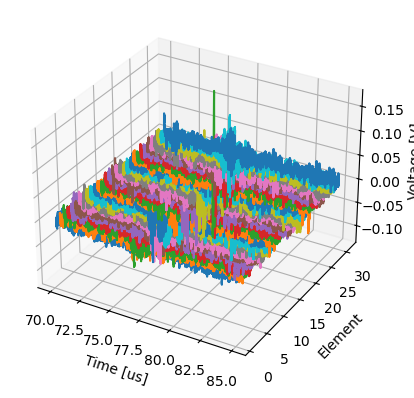

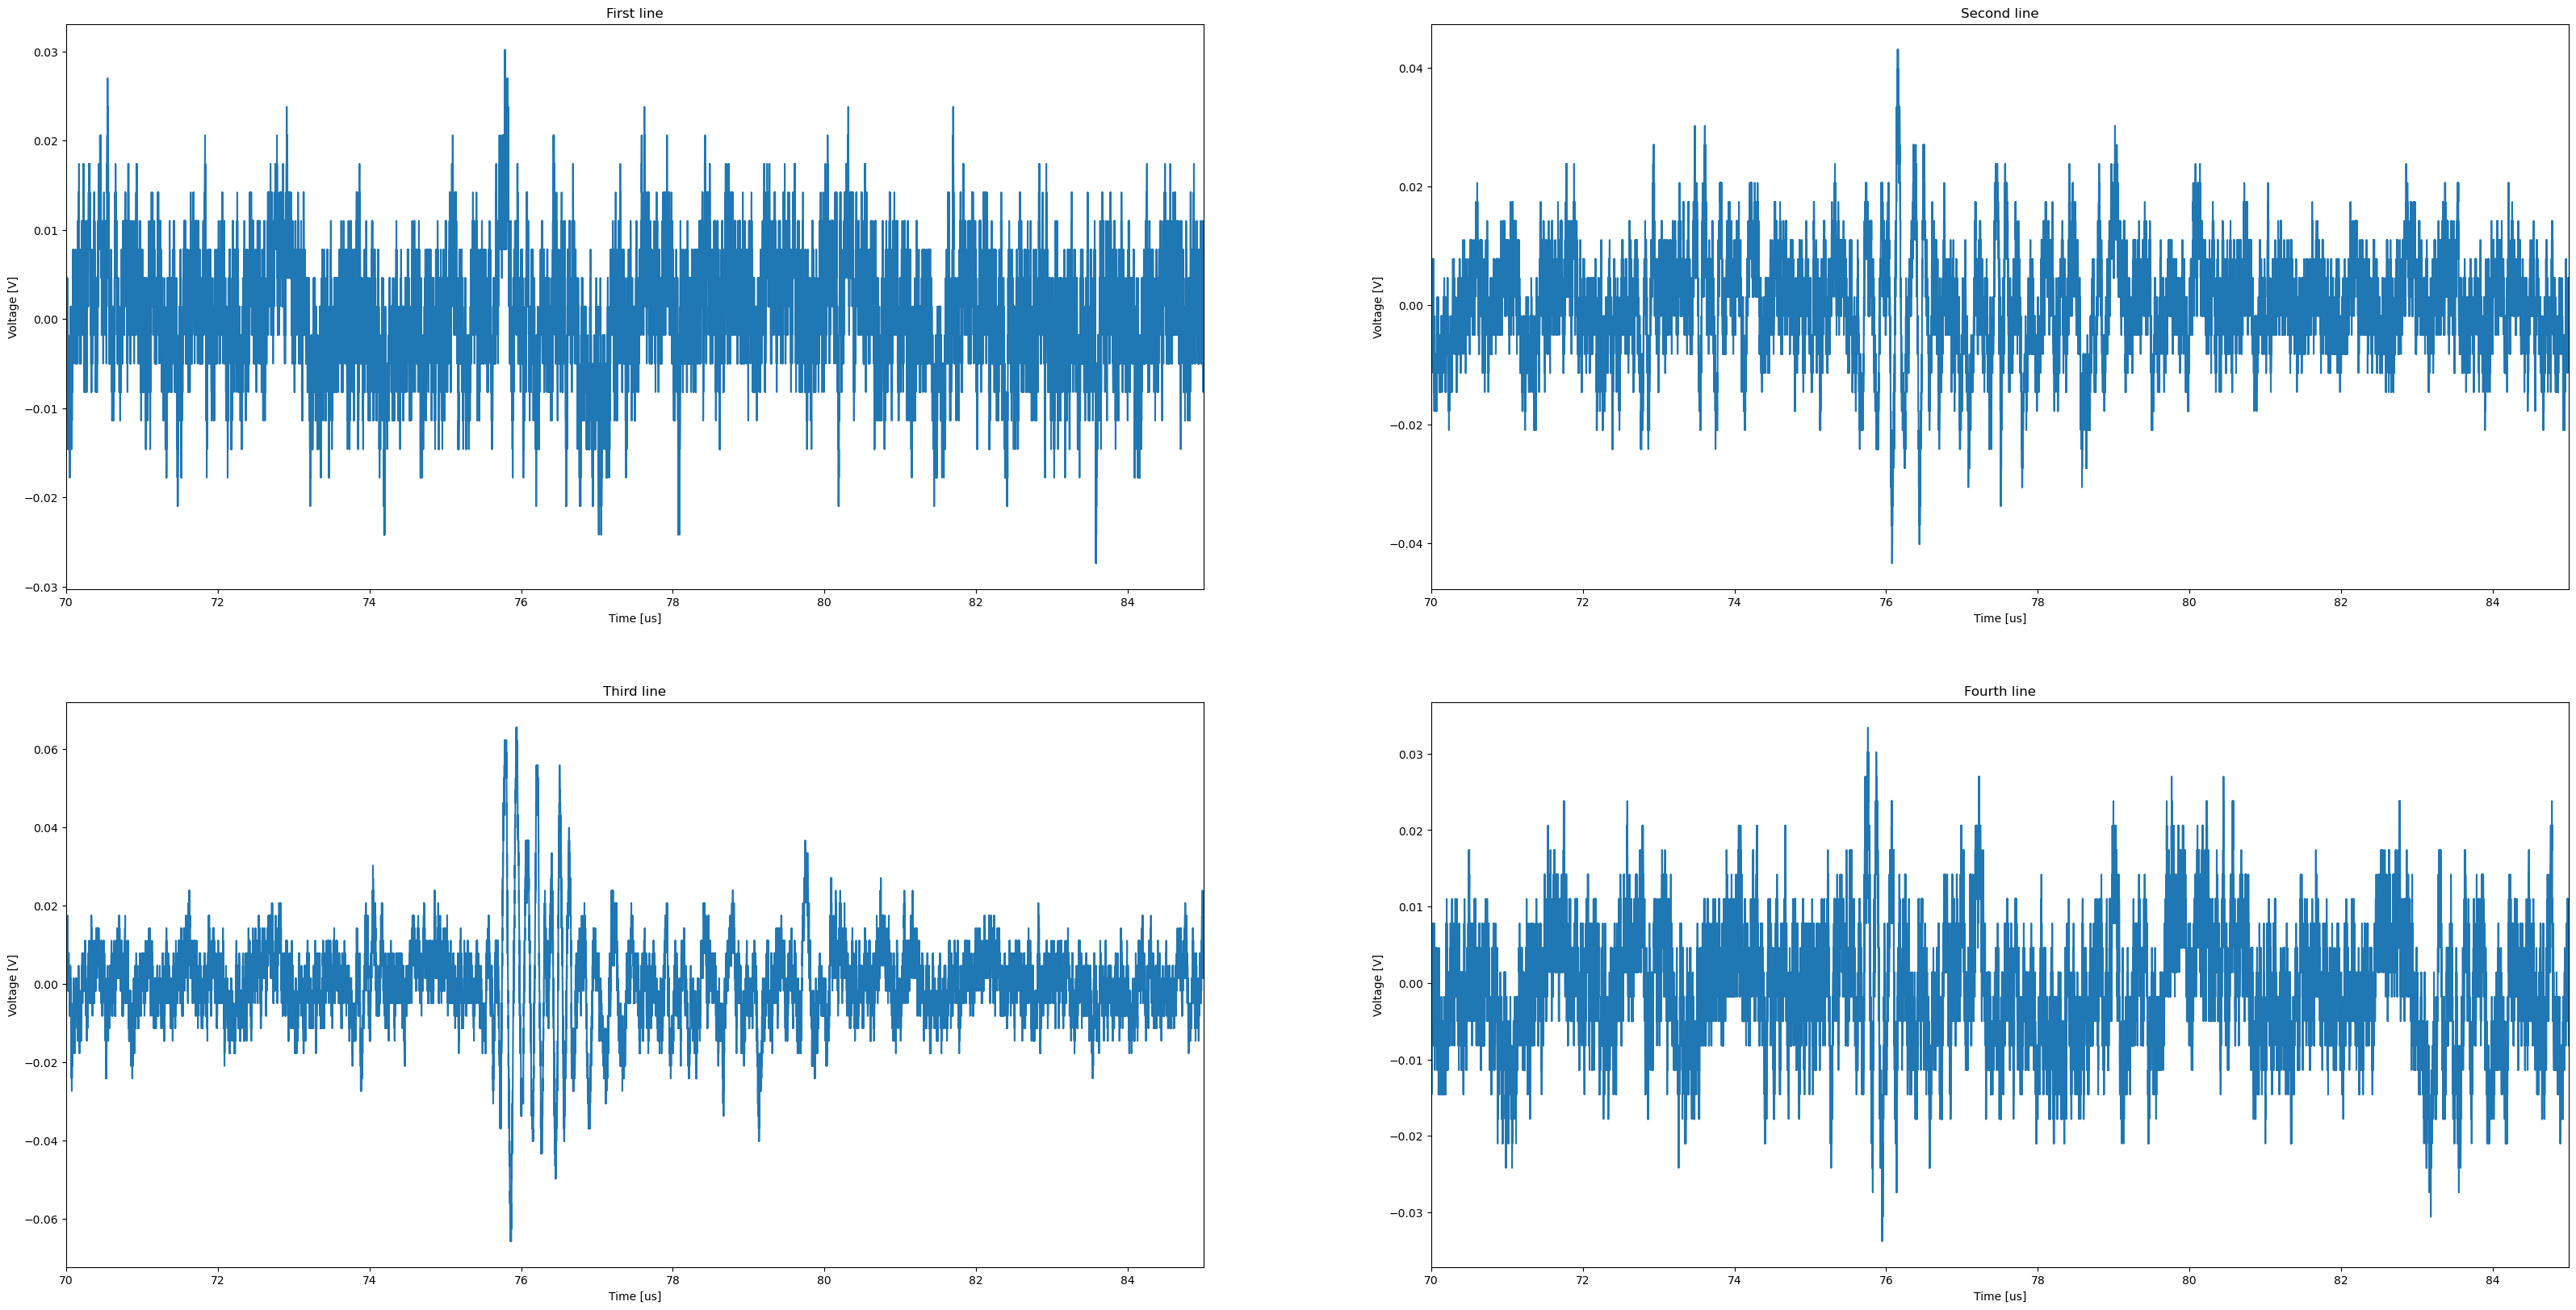

In [18]:
# Plot all data
plot_all_lines(data)

plt.subplots(2, 2, figsize=(40, 20))
# Plot the first line
plt.subplot(2, 2, 1)
plot_line(data, title='First line', line=0)
# Plot the second line
plt.subplot(2, 2, 2)
plot_line(data, title='Second line', line=1)
# Plot the third line
plt.subplot(2, 2, 3)
plot_line(data, title='Third line', line=2)
# Plot the fourth line
plt.subplot(2, 2, 4)
plot_line(data, title='Fourth line', line=3)

### Preprocessing
We can do many preprocessing steps. Here, we will just remove the DC component.

Removing DC component


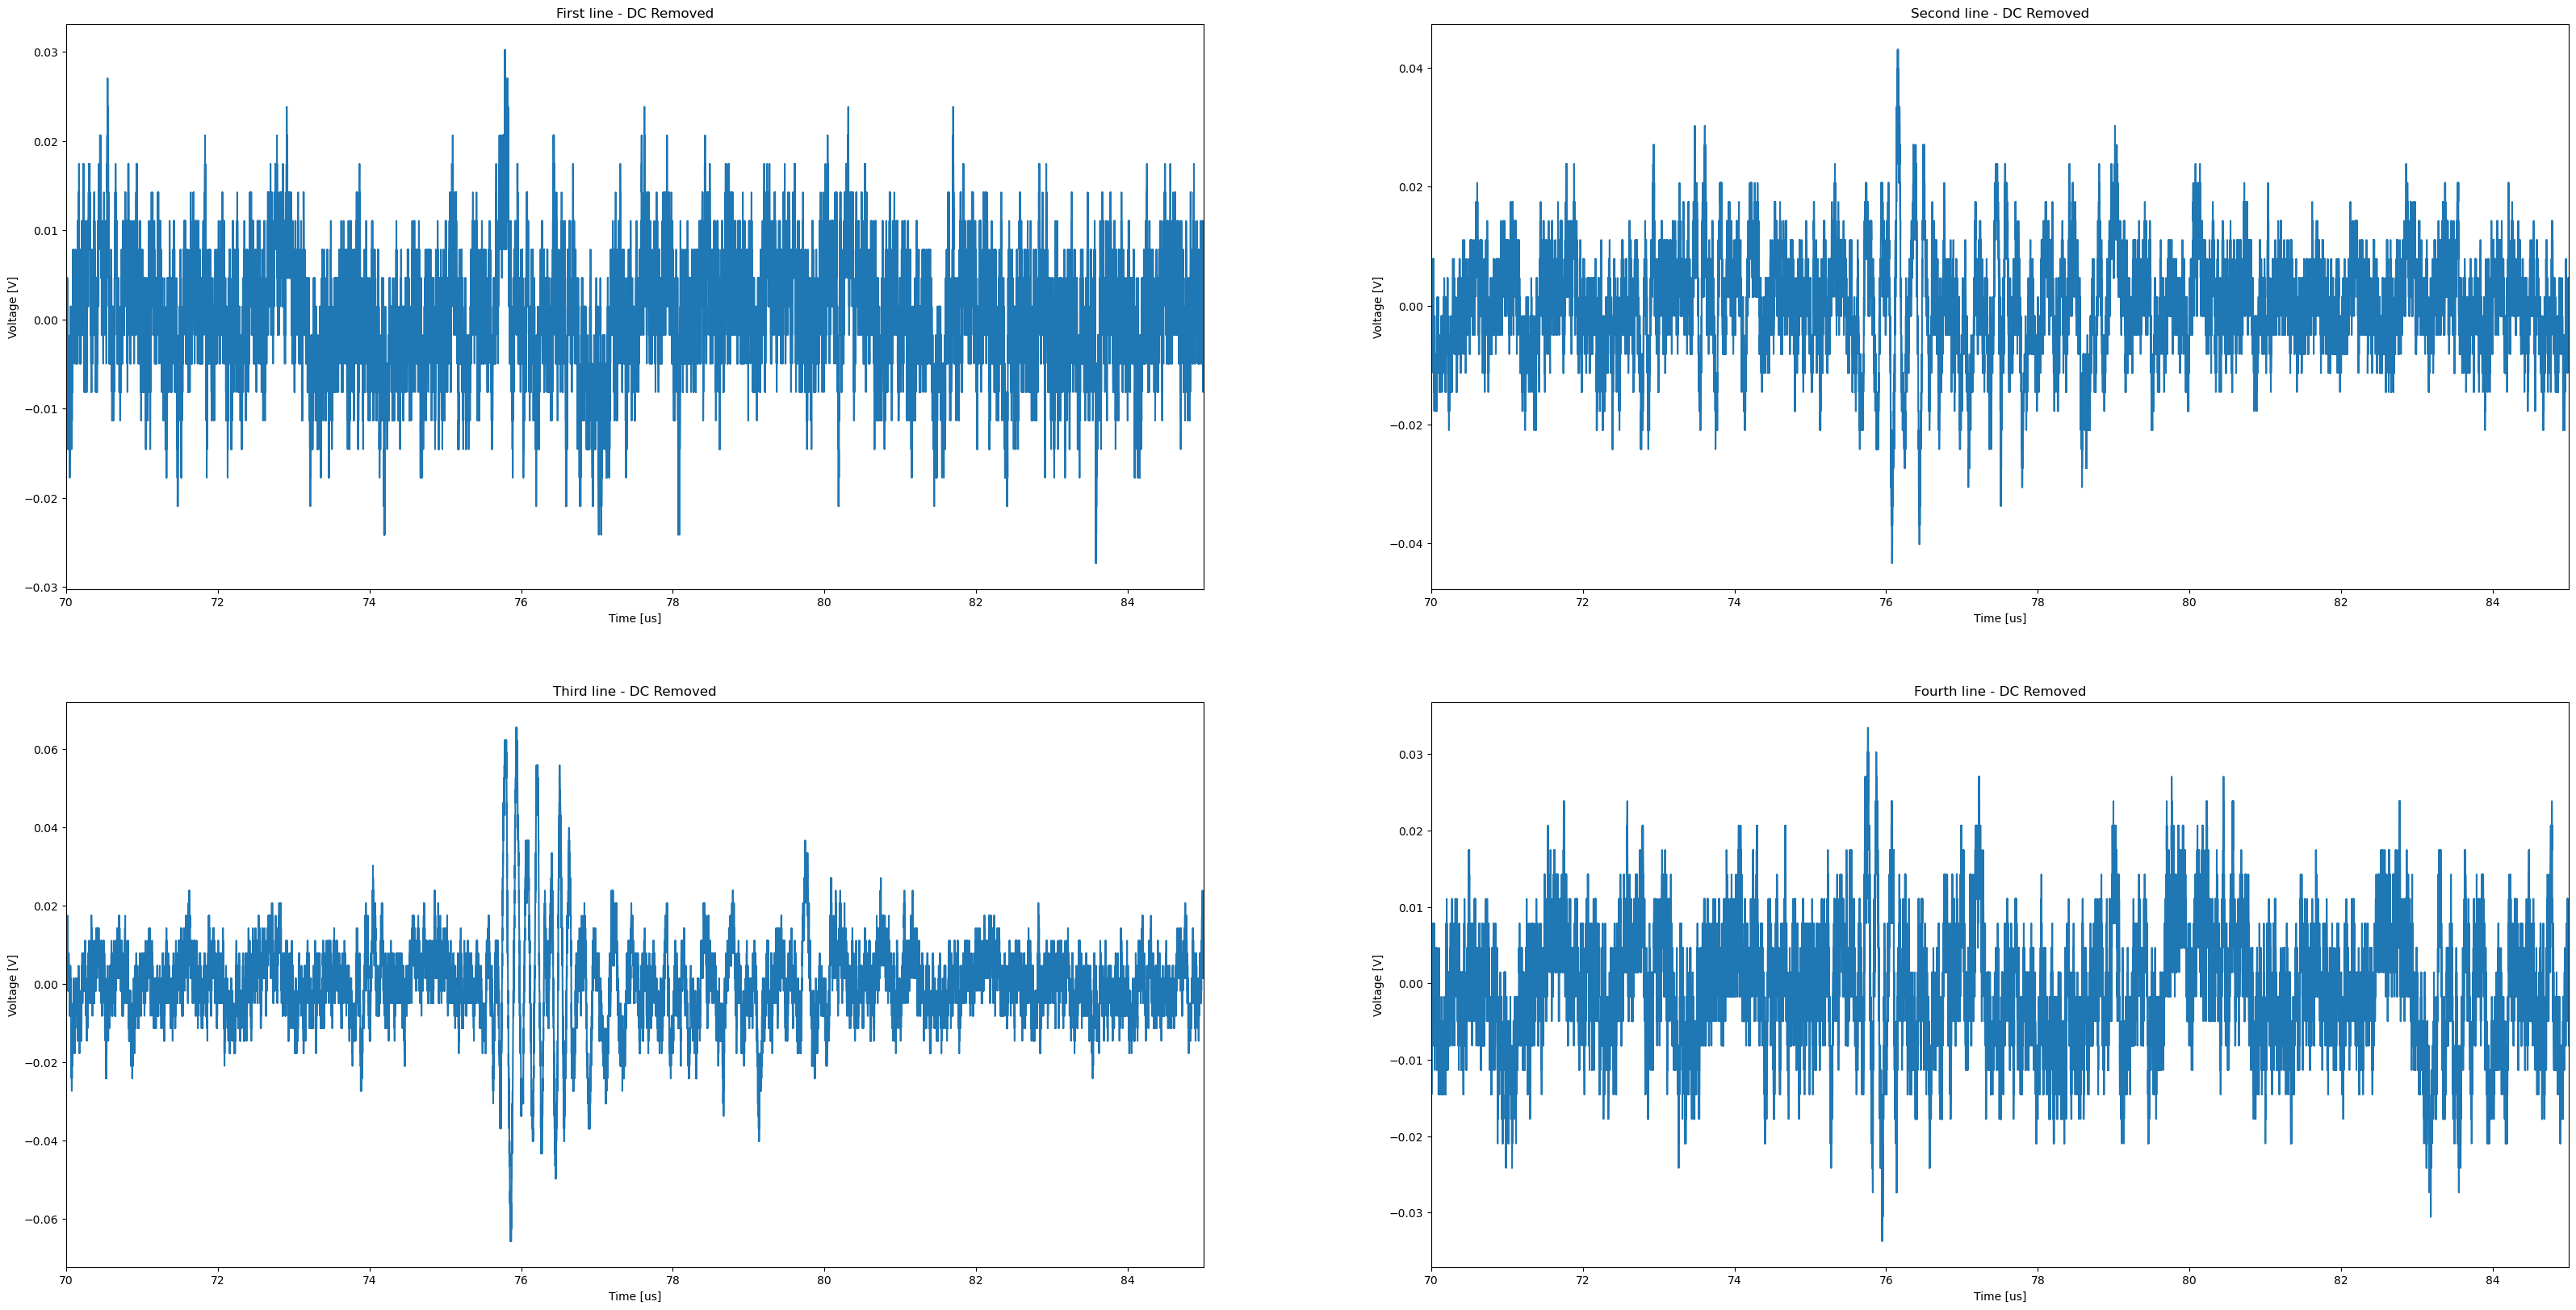

In [19]:
# Perform Standard pre-processing
plt.subplots(2, 2, figsize=(40, 20))

print('Removing DC component')

remove_dc(data)

# Plot the first line
plt.subplot(2, 2, 1)
plot_line(data, title='First line - DC Removed', line=0)
# Plot the second line
plt.subplot(2, 2, 2)
plot_line(data, title='Second line - DC Removed', line=1)
# Plot the third line
plt.subplot(2, 2, 3)
plot_line(data, title='Third line - DC Removed', line=2)
# Plot the fourth line
plt.subplot(2, 2, 4)
plot_line(data, title='Fourth line - DC Removed', line=3)

### Frequency Spectrum
We're interested in the frequency spectrum to see what frequency content is contained in the signal.

We can see from the spectrum where we have a peak and if there is one at the resonance frequency of that transducer around $7.5MHz$. If multiple other peaks registered from low frequency components as well this can be adjusted by the right parameters in the Pulser/Receiver and using analog and digital filtering on the signal. 

Resonance frequency for line 1 is 0.13332977787259007 MHz
Resonance amplitude for line 1 is 31.716440256983987
Resonance frequency for line 2 is 4.666542225540652 MHz
Resonance amplitude for line 2 is 35.49423590031628
Resonance frequency for line 3 is 6.733153782565798 MHz
Resonance amplitude for line 3 is 46.68949246186766
Resonance frequency for line 4 is 0.39998933361777017 MHz
Resonance amplitude for line 4 is 37.13690444682822


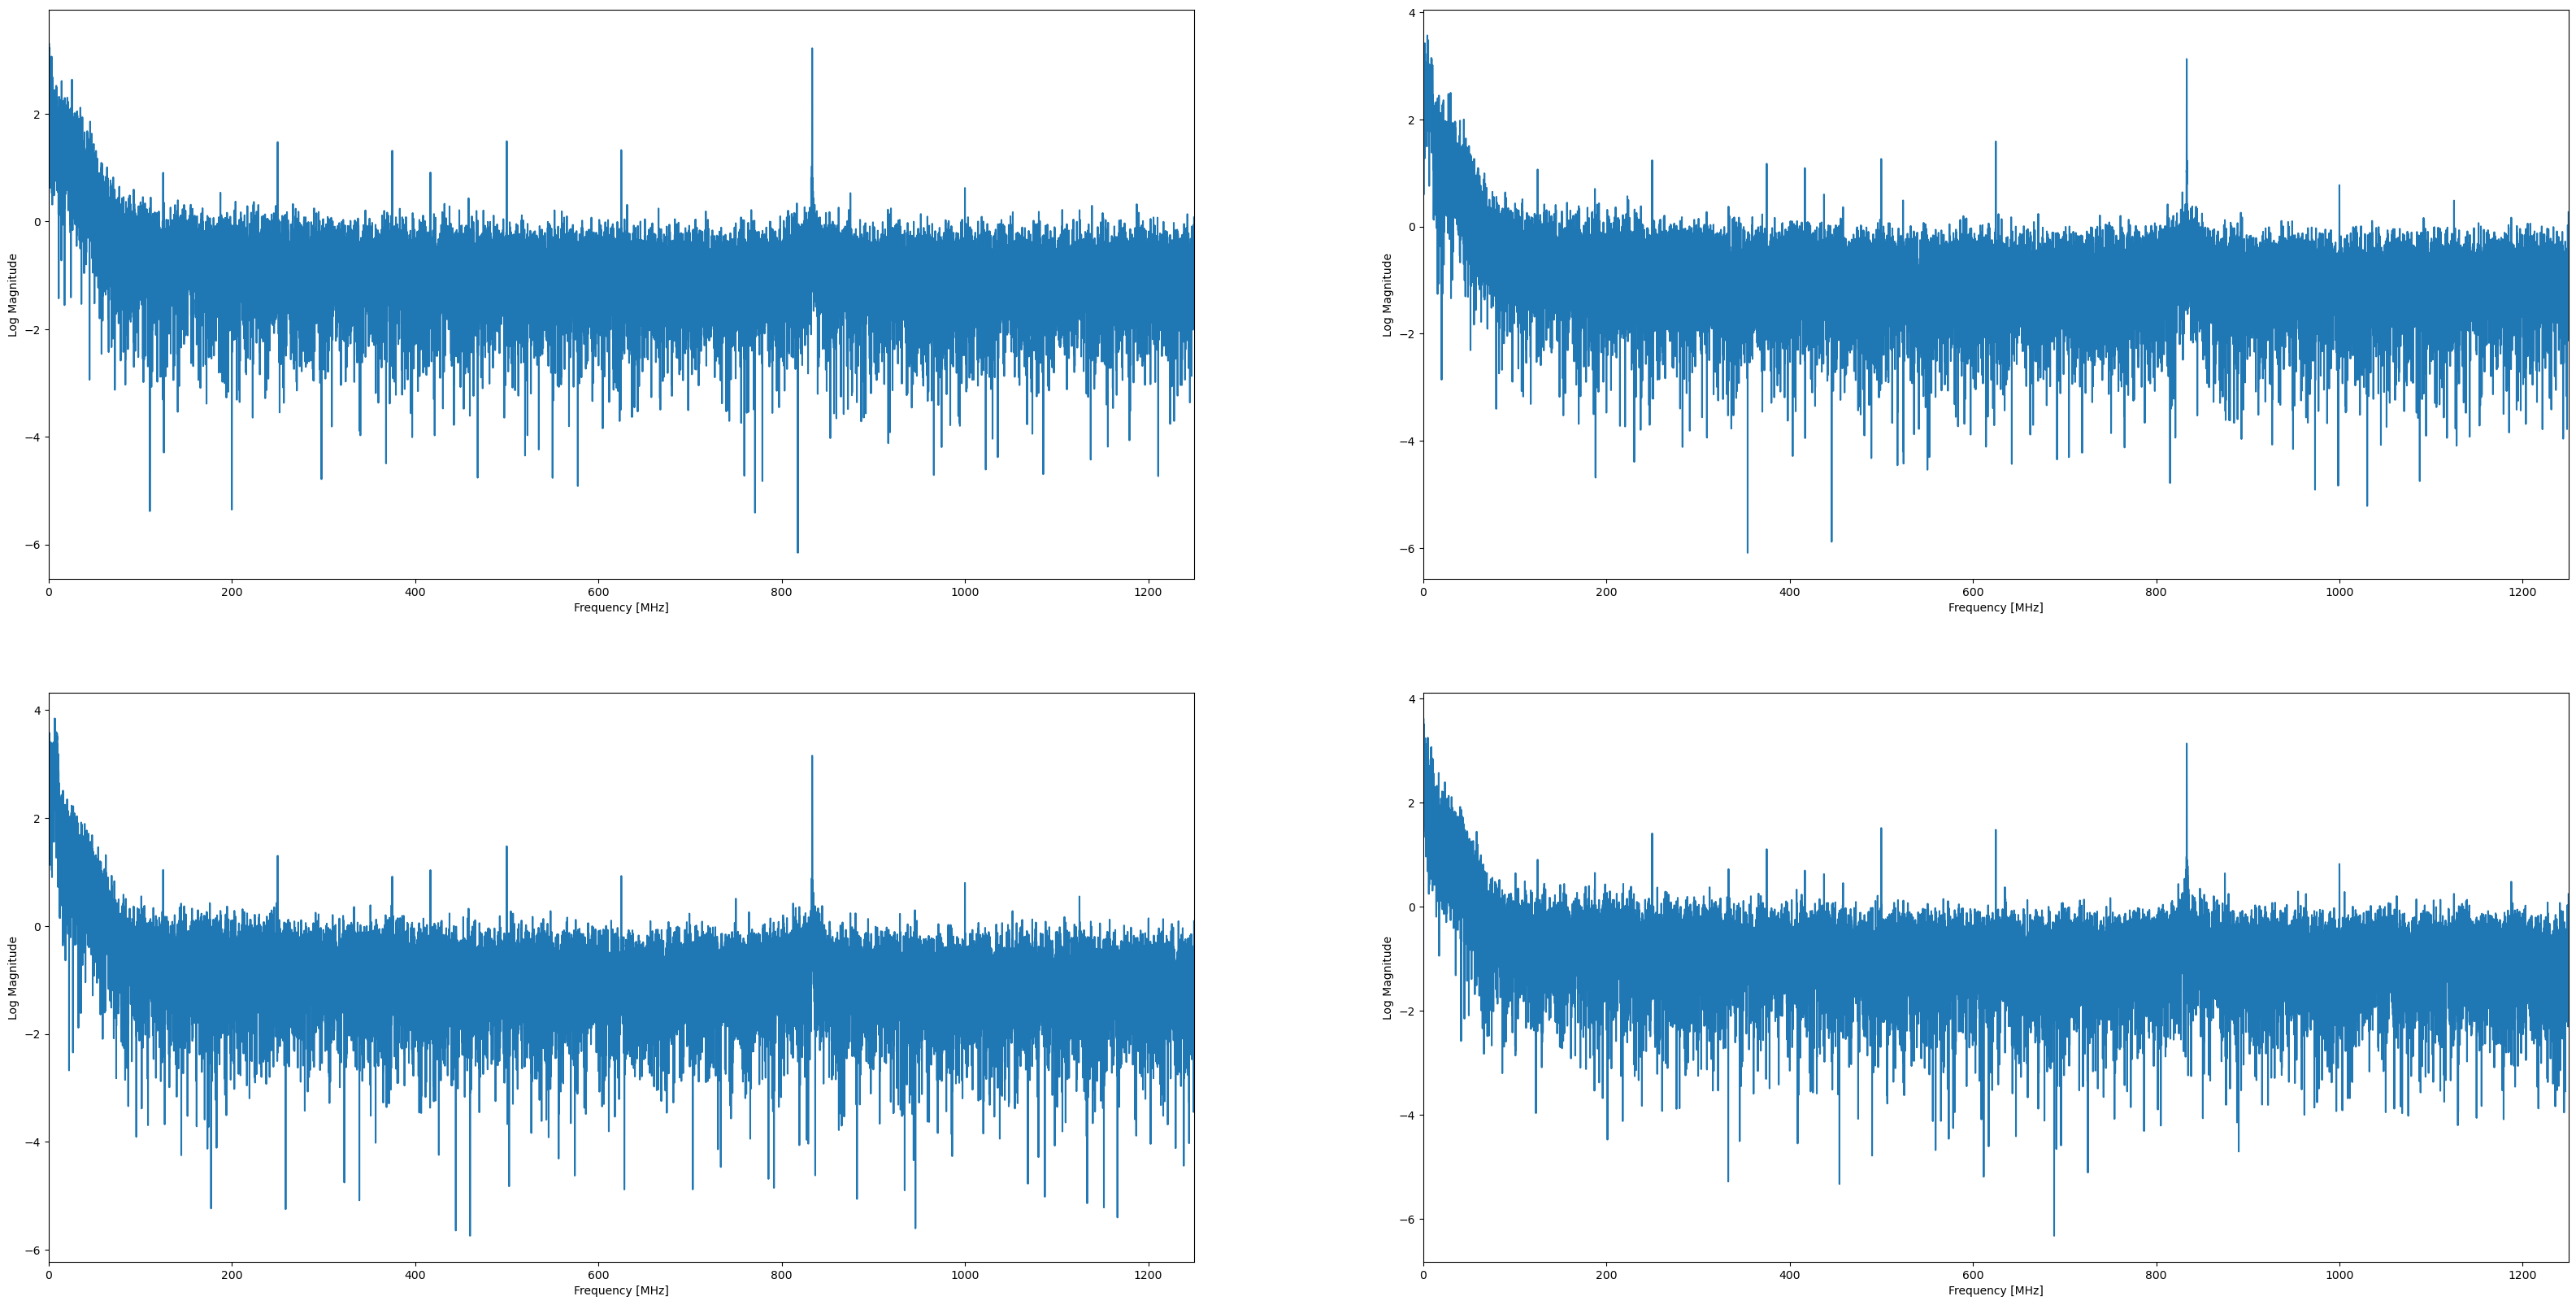

In [20]:
plt.subplots(2, 2, figsize=(40, 20))

# Plot the first line
plt.subplot(2, 2, 1)
f_res, a_res = frequency_spectrum(data,line=0)
print('Resonance frequency for line 1 is {} MHz'.format(f_res / 1e6))
print('Resonance amplitude for line 1 is {}'.format(a_res))

# Plot the second line
plt.subplot(2, 2, 2)
f_res, a_res = frequency_spectrum(data,line=1)
print('Resonance frequency for line 2 is {} MHz'.format(f_res / 1e6))
print('Resonance amplitude for line 2 is {}'.format(a_res))

# Plot the third line
plt.subplot(2, 2, 3)
f_res, a_res = frequency_spectrum(data,line=2)
print('Resonance frequency for line 3 is {} MHz'.format(f_res / 1e6))
print('Resonance amplitude for line 3 is {}'.format(a_res))

# Plot the fourth line
plt.subplot(2, 2, 4)
f_res, a_res = frequency_spectrum(data,line=3)
print('Resonance frequency for line 4 is {} MHz'.format(f_res / 1e6))
print('Resonance amplitude for line 4 is {}'.format(a_res))

## Time Gain Compensation
Assuming that the tissues have attenuated this signal $4Np/m/MHz$ we will compensate for this attenuation and plot the real time-gain-compensated signal. The attenuation is exponential so we can compensate using:

$$ RF_{com}=RF e^{\mu d}\;\;\mu=\alpha f\;\;\;\;\;d=ct\;\;\;c\approx 1500m/s$$

Performing TGC


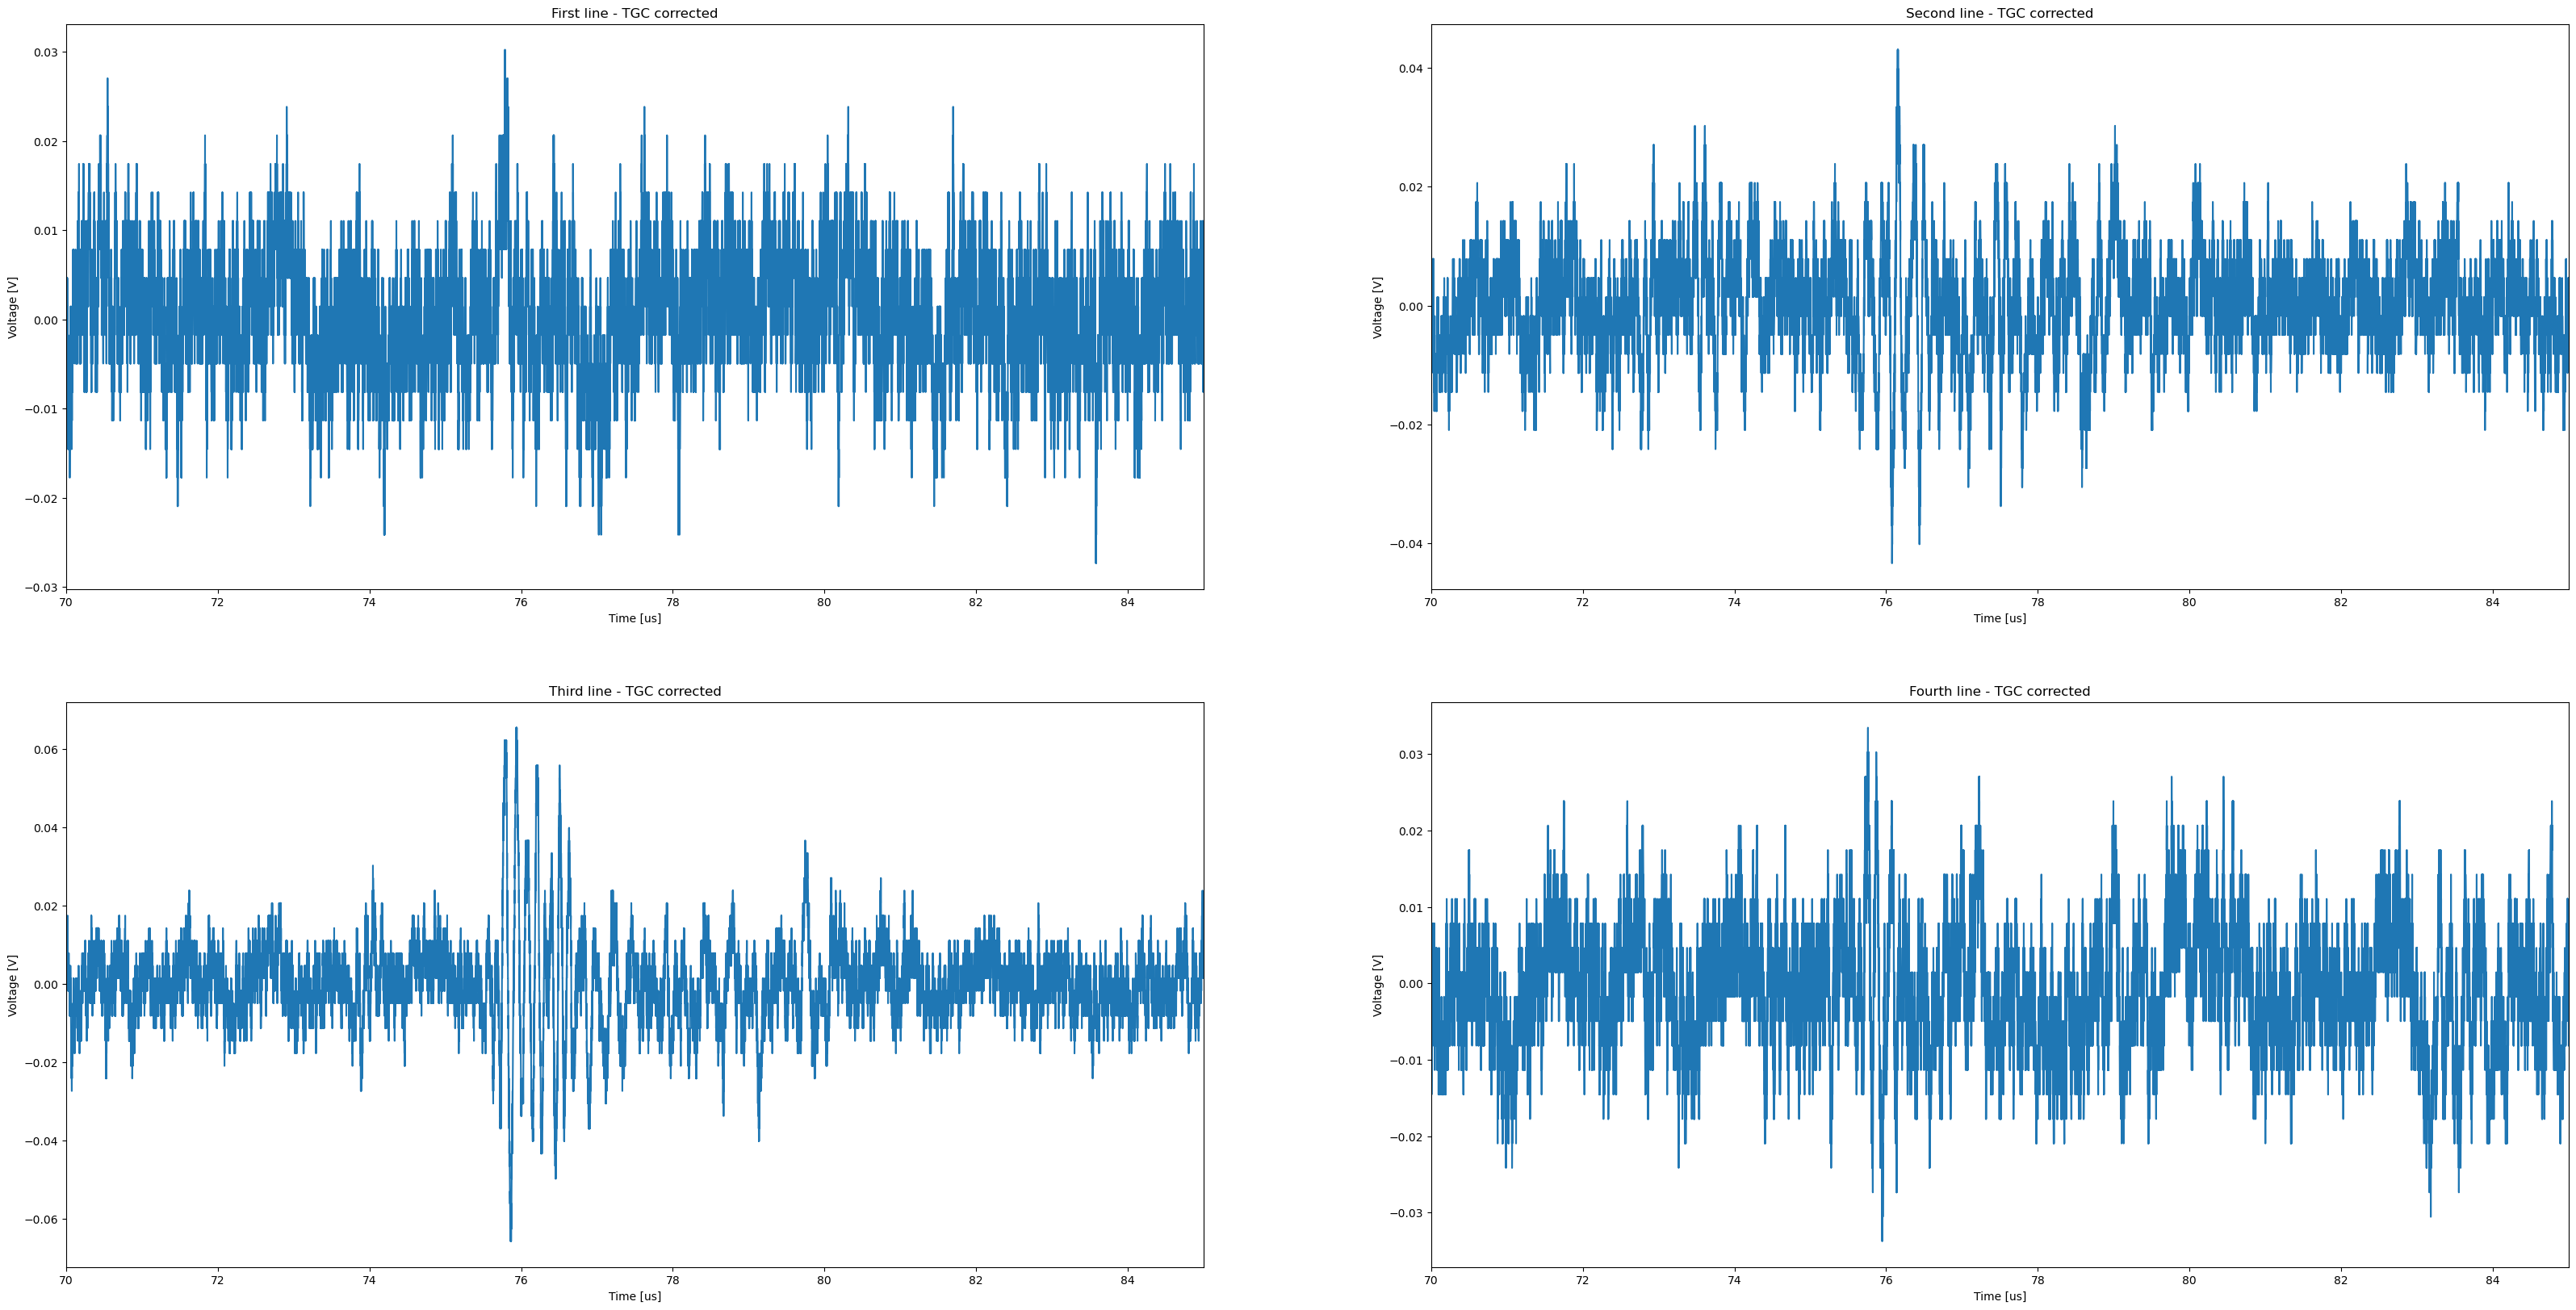

In [21]:
plt.subplots(2, 2, figsize=(40, 20))

print('Performing TGC')

time_gain_compensation(data, speed_of_sound, attenuation, transducer_frequency)

# Plot the first line
plt.subplot(2, 2, 1)
plot_line(data, title='First line - TGC corrected', line=0)
# Plot the second line
plt.subplot(2, 2, 2)
plot_line(data, title='Second line - TGC corrected', line=1)
# Plot the third line
plt.subplot(2, 2, 3)
plot_line(data, title='Third line - TGC corrected', line=2)
# Plot the fourth line
plt.subplot(2, 2, 4)
plot_line(data, title='Fourth line - TGC corrected', line=3)

### Envelope Detection
To prepare for forming an image, we will now obtain the envelope of the signal and plot. This is done using a Hilbert transform.

Performing Evelope Detection


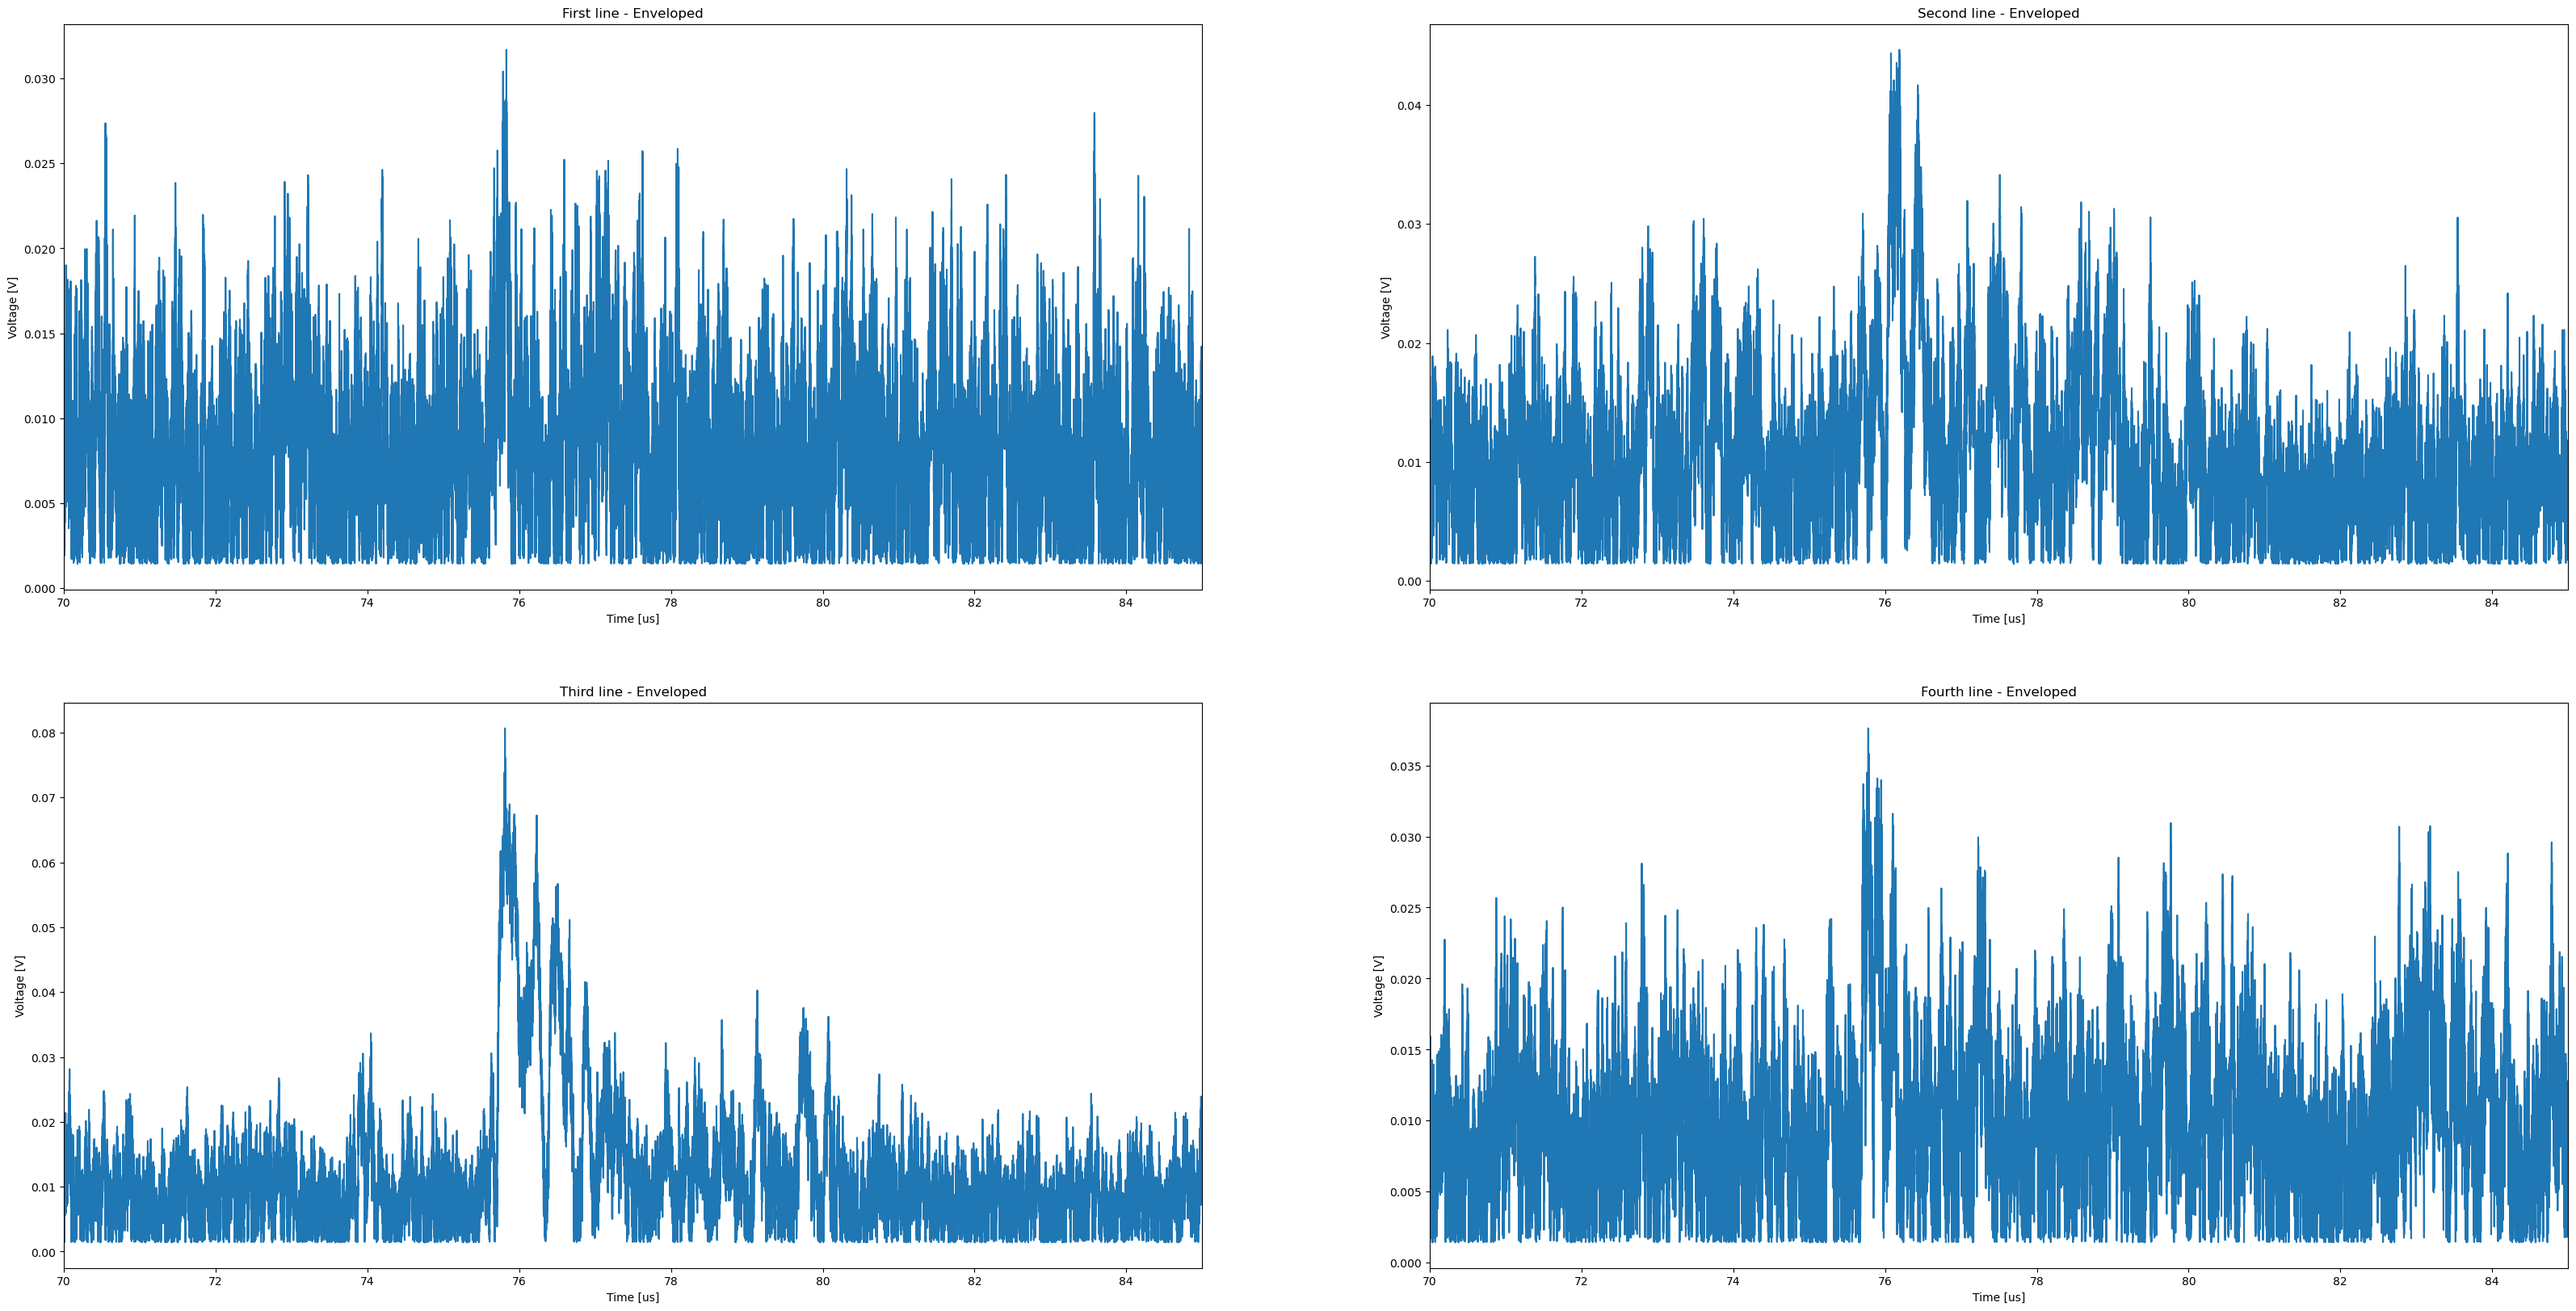

In [22]:
plt.subplots(2, 2, figsize=(40, 20))

print('Performing Evelope Detection')

envelope_detector(data)

# Plot the first line
plt.subplot(2, 2, 1)
plot_line(data, title='First line - Enveloped', line=0)
# Plot the second line
plt.subplot(2, 2, 2)
plot_line(data, title='Second line - Enveloped', line=1)
# Plot the third line
plt.subplot(2, 2, 3)
plot_line(data, title='Third line - Enveloped', line=2)
# Plot the fourth line
plt.subplot(2, 2, 4)
plot_line(data, title='Fourth line - Enveloped', line=3)

### Image Reconstruction

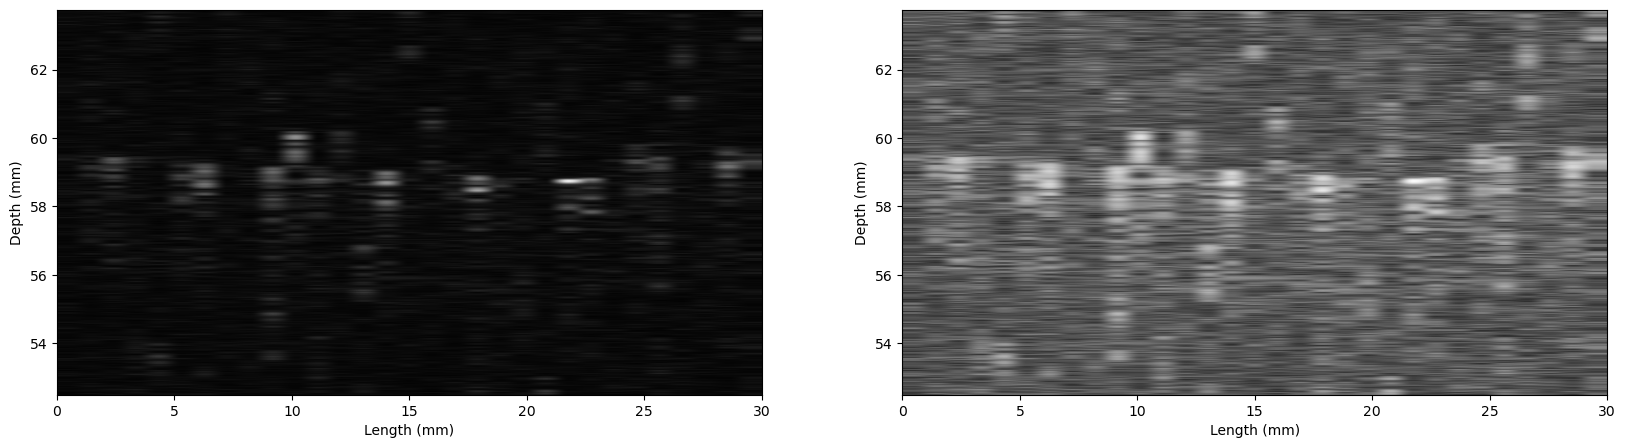

In [23]:
image, depth, transeiver_width = reconstruct_image(data, speed_of_sound, line_width)

plt.subplots(1, 2, figsize=(20, 5))
plt.subplot(1, 2, 1)
plot_us_image(image, depth, transeiver_width, use_log=False)
plt.subplot(1, 2, 2)
plot_us_image(image, depth, transeiver_width, use_log=True)

### Image Filtering
We will finally apply one of the most common filters that are used in ultrasound imaging: the median filter. This will make the image less "grainy" to the user. We will also implement a usual "cutoff" in the displayed image, anything less than -60dB will be eliminated. This will work best with actual tissues than for perfect reflectors, why?

/var/folders/tm/sspyv08j21q74x7dxt8th_l00000gn/T/ipykernel_19899/2476285365.py:7: RuntimeWarning: divide by zero encountered in divide
  this_image= 20*np.log10(this_image / np.max(this_image.ravel()) + 1e-6)
/var/folders/tm/sspyv08j21q74x7dxt8th_l00000gn/T/ipykernel_19899/2476285365.py:7: RuntimeWarning: invalid value encountered in divide
  this_image= 20*np.log10(this_image / np.max(this_image.ravel()) + 1e-6)
/var/folders/tm/sspyv08j21q74x7dxt8th_l00000gn/T/ipykernel_19899/2476285365.py:7: RuntimeWarning: invalid value encountered in log10
  this_image= 20*np.log10(this_image / np.max(this_image.ravel()) + 1e-6)


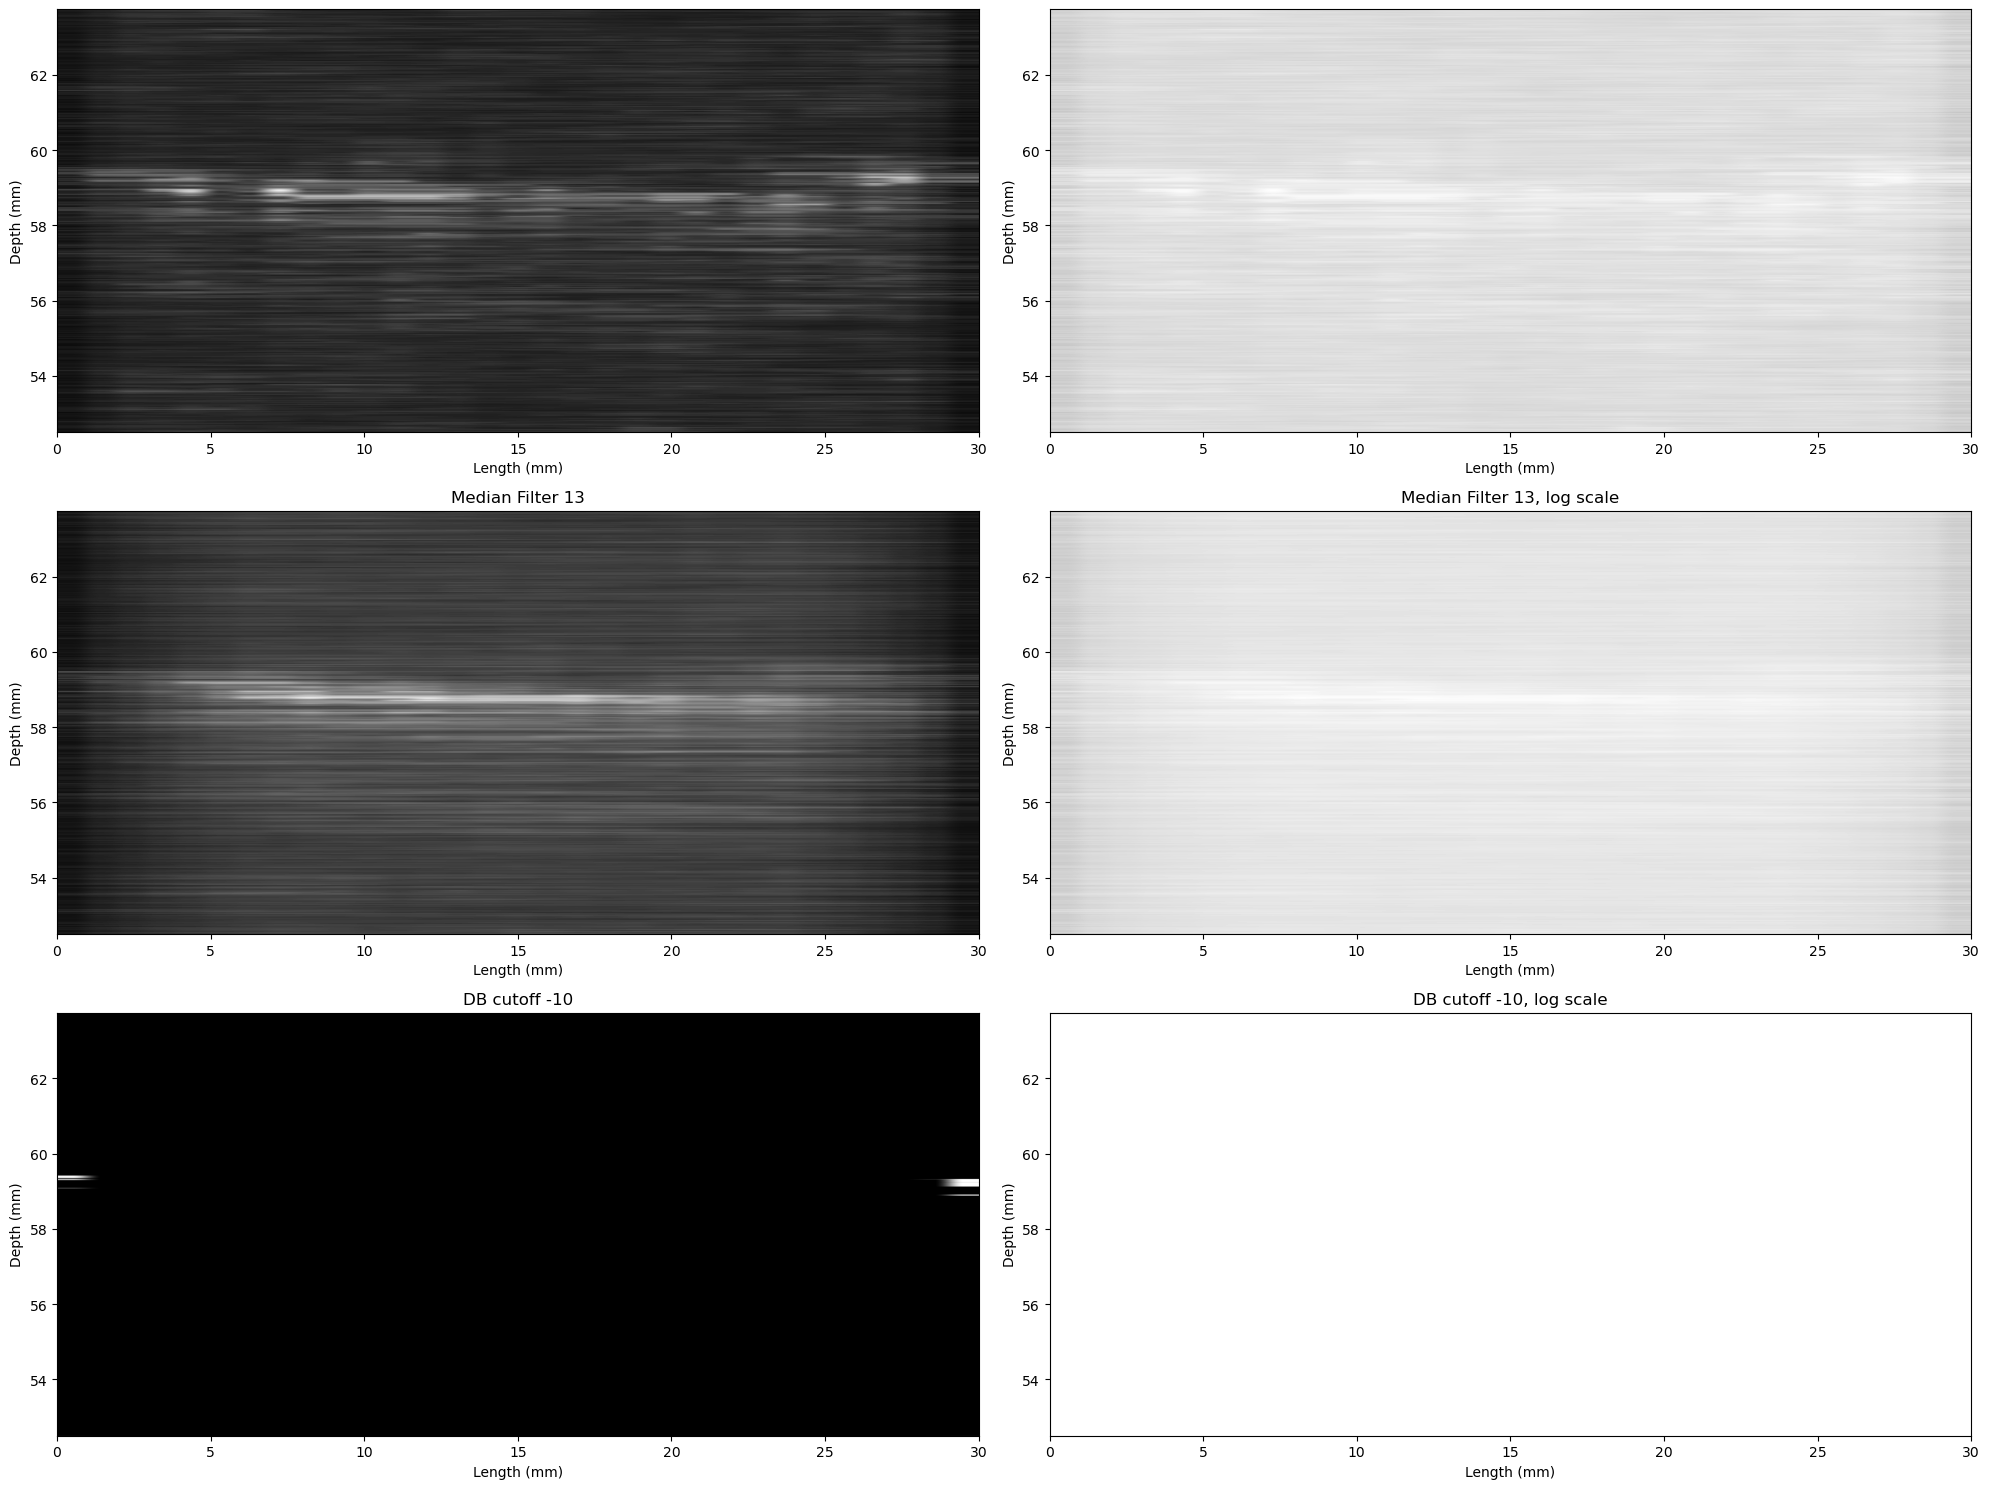

In [26]:
# Remove low response
med_image = image.copy()
med_image_10 = image.copy()
cutdb=-60
cutdb_10 =-10
db_img = 20*np.log10(image / np.max(image.ravel()) + 1e-6)

inx=np.where(db_img<cutdb)
med_image[inx]=cutdb
inx_10 = np.where(db_img<cutdb_10)
med_image_10[inx_10]=cutdb_10

# Median filter
med_image1 = signal.medfilt(med_image, 5)
med_image2 = signal.medfilt(med_image.copy(), 13)
med_image_10 = signal.medfilt(med_image_10, 5)

plt.subplots(3, 2, figsize=(20, 15))
plt.subplot(3, 2, 1)
plot_us_image(med_image1, depth, transeiver_width, use_log=False)
plt.subplot(3, 2, 2)
plot_us_image(med_image1, depth, transeiver_width, use_log=True)
plt.subplot(3, 2, 3)
plt.title("Median Filter 13")
plot_us_image(med_image2, depth, transeiver_width, use_log=False)
plt.subplot(3, 2, 4)
plt.title("Median Filter 13, log scale")
plot_us_image(med_image2, depth, transeiver_width, use_log=True)
plt.subplot(3, 2, 5)
plt.title("DB cutoff -10")
plot_us_image(med_image_10, depth, transeiver_width, use_log=False)
plt.subplot(3, 2, 6)
plt.title("DB cutoff -10, log scale")
plot_us_image(med_image_10, depth, transeiver_width, use_log=True)

plt.tight_layout()

## Question 3 - Image Formation

Answer to the following questions:
<br>1. Is the frequency calculated with the notebook close to the values you calculated in Question 2, sub-question 3 (the value you calculated from the observed signal in the oscilloscope)? Explain what can explain any large and small differences.

The frequency for 4 of the lines in the data set are the following:


<br>Resonance frequency for line 1 is 0.13332977787259007 MHz
<br>Resonance frequency for line 2 is 4.666542225540652 MHz
<br>Resonance frequency for line 3 is 6.733153782565798 MHz
<br>Resonance frequency for line 4 is 0.39998933361777017 MHz


The calculated Frequency was 6.90 MHz. as seen by the 4 line datas only one is close by having a 96% relative degree of closeness. The other 3 values stand at roughly 4.7, 0.13, and 0.40. This is most likely attributed to the filters and Notebook accounting for the bumps in the echos. The large Bumps symbolize a difference in acoustic impedance within the water and object as the waves are getting reflected back thus the times will vary when the wave gets sent and comes back therefore changing the frequency given.


<br>2. Is the frequency close to the value expected for this transducer? Why?

No this is due to the time difference between the emission of the ultrasound wave and the reception of the echo.

<br>3. Discuss the aspect of the reflectors in the image. Why are they not perfect points?

This is due to scattering as the waves reflect of the object it can be unpredictably and therefore they don’t often reflect back directly to the transducer as the object is often not a flat smooth surface and small particles can alter the path the waves reflect back.


<br>4. Make a sketch of the steps in the code used to form the image including the title of the sections in this notebook and the names of the functions used
 
See PDF.

<br>5. Investigate what is the Hilbert transform and how is the mathematical expression related to the used in the code (i.e. envelope detection)

https://opg.optica.org/ol/abstract.cfm?uri=ol-25-2-99#:~:text=The%20Hilbert%20transform%20is%20useful,arbitrarily%20shaped%20two%2Ddimensional%20objects.


Hilbert Transformation is enhacing the values at the edges where a object may be seen inside of the image. In this case for the envelope detection we are taking the absolute value of the values given and then creating an image with a higher contrast.


<br>6. Compare your reconstructed image to the objects that were imaged and explain the corresponding object and how did you determine this

Given the Ultrasound and the images formed we can assume the object is several straight lines due to the difference in contrast when looking at the image, where the white or lighter areas represent the object and the black represents the background.

<br>7. Compare your reconstructed image to the one obtained by your team member(s) with a different dataset, discuss the differences you observe and what could explain them

When comparing with Test_Iamge from D2L the test iamge compared to the computed notebook image is much more clearer and defined this is most likely due to a decrease in distance between the transducer. It could also be that some of the Filters used such as the High Pass Filter and this assumption is due to the fact that the core of the object is still detected however the edges are not as defined as the Test_Image.




*Add your answer here*

## Question 4 - Image Filtering

Answer to the following questions:
<br>1. What is the effect of increasing the kernel size of the filter?

Increasing the size of the kernal makes the image more blurry when comapring med_image1 and med_image2 where med_image1 has a kernal size of 5

<br>2. What is the effect of modifying the cut levels for the image?


The effects of the cutoff is essentially limiting the amount of lighter pixels to a certain amount from 0-255 within the image and replacing them black pixels.


<br>3. Can any of the features in the image be seen appropriately without logarithmic scaling? Why?

When looking at the images with logarithmic scaling we can see that the image are more defined in its feautres as the logarithmic scaling increase the contrast of the whole image however the blurring effect is reduced due to the contrast being higher in the core of the features present.

<br>4. Why was the value of attenuation fixed to 0 Np/m/MHz for this code?

Attenuation is 0 since the wave directly reflect instead of going through object like how it is traditionally used, since traditionally it has to go through things such as body tissues and then reflecting back causing lower energy and intensity output.

<br>5. What is the line in the code that performs TGC?

This is the following that calls for it
<br>time_gain_compensation(data, speed_of_sound, attenuation, transducer_frequency)

with the following computations being done here:
<br> compensation = np.exp(attenuation * transducer_frequency * depth)
    
    voltage = data[ 'data' ][0]
    
    voltage[:,:] = voltage * compensation

*Add your answer here*

### Conclusion

In this lab we looked at transducer and how to set up an environment to emulate a scenario where the transducer has a distance greater then 1cm between the object and transducer while also following safety measures. We looked at how water effects an ultrasound and given the data obtained we were able to calculate Frequency and Distance. Once several more Data sets were obtained we used several calculations and tools such as Kernels,  Hilbert transform, logarithmic scaling, time gain compensation, and Cut offs for pixels for image transformations and filtering.